# Old Script

In [ ]:
import h5py
import numpy as np
from yaml import safe_load
from sys import getsizeof
import random

def give_random_internval(dim_shape = None, AROUND = None, lower = None, upper = None):
    # RANDOM_POS = np.random.randint(AROUND+10, dim_shape - AROUND-10-80)
    if ((upper+AROUND) >= (dim_shape - AROUND-10-80)):
        RANDOM_POS = (np.random.randint(10 + AROUND, lower - AROUND - 80))
    elif((10 + AROUND) >= (lower - AROUND - 80)):
        RANDOM_POS = (np.random.randint(upper+AROUND, dim_shape - AROUND-10-80))
    else:
        RANDOM_POS = random.choice([np.random.randint(10 + AROUND, lower - AROUND - 80),
                            np.random.randint(upper+AROUND, dim_shape - AROUND-10-80)])
    return slice(RANDOM_POS - AROUND, RANDOM_POS +AROUND +80)


def main():
    # load configurations
    print("[INFO] Loading vars")
    with open("./config.yml", 'r') as file:
        config_var = safe_load(file)["preparation"]
    data_path = config_var['input_path']
    print("[INFO] Preparing data")
    h5f = h5py.File(data_path)
    images = h5f["data"] # (1460,16,768,1152) numpy array
    boxes = h5f["boxes"] # (1460,15,5) numpy array

    # size of the box around the anomaly to be taken
    AROUND = config_var['around']
    if config_var["cyclon"]:
        # Takes a long time to create
        print("[INFO] Get cyclon train data")
        data_with_cyclon = [
                images[i, :, (cyclon[0] - AROUND):(cyclon[0] + 80 + AROUND),
                (cyclon[1] - AROUND):(cyclon[1] + 80 + AROUND)]
                for i, box in zip(range(images.shape[0]), boxes)
                for cyclon in box[(box[:, -1] == 2) | (box[:, -1] == 1)]
        ]
        print("RAM usage for array: %.4fMB" % (float(getsizeof(data_with_cyclon)) * 1e-6))
        # just remove the ones with smaller shape
        data_with_cyclon = [el for el in data_with_cyclon if el.shape == data_with_cyclon[0].shape]

        data_with_cyclon = np.stack(data_with_cyclon, axis = 0)
        print("[INFO] Preparing output file")
        hf = h5py.File(config_var['output_path']+'train_pos.h5', 'w')
        hf.create_dataset('positive', data = data_with_cyclon, compression = 'gzip')
        print("[INFO] Saving output file")
        hf.close()
    else:
        # Takes a long time to create
        print("[INFO] Get non-cyclon train data")
        # using the second loop i can get the same amount of data as the first one
        data_without_cyclon = [images[i, :,
                             give_random_internval(images.shape[2], AROUND = AROUND, lower = cyclon[0], upper = cyclon[2]),
                             give_random_internval(images.shape[3], AROUND = AROUND, lower = cyclon[1], upper = cyclon[3])]
                       for i, box in zip(range(images.shape[0]), boxes)
                       for cyclon in box[(box[:, -1] == 2)
                                         | (box[:, -1] == 1)]]
        data_without_cyclon = np.stack(data_without_cyclon, axis = 0)
        print("[INFO] Preparing output file")

        hf = h5py.File(config_var['output_path']+'train_neg.h5', 'w')
        hf.create_dataset('negative', data = data_without_cyclon, compression = 'gzip')
        print("[INFO] Saving output file")
        hf.close()

if __name__ == "__main__":
    main()

# New Script

In [1]:
import h5py
import numpy as np
from yaml import safe_load
from sys import getsizeof
import random
from warnings import warn
from progressbar import progressbar

In [11]:
# load configurations
print("[INFO] Loading vars")
with open("./config.yml", 'r') as file:
    config_var = safe_load(file)["geo_localize"]
data_path = config_var['input_path']
print("[INFO] Preparing data")
h5f = h5py.File(data_path)
images = h5f["data"] # (1460,16,768,1152) numpy array
boxes = h5f["boxes"] # (1460,15,5) numpy array
lats = h5f['latitude']
lons = h5f['longitude']
times = h5f['time']

# size of the box around the anomaly to be taken
box_size = config_var['box_size']

[INFO] Loading vars
[INFO] Preparing data


In [139]:
def get_box_lat(around=None,
                diff_lats=0.23468057366362416,
                lat_cyclon_min=None,
                lat_cyclon_max=None):
    if diff_lats < 0:
        warn("Negative step given. Changing sign to have positive value.")
        diff_lats = abs(diff_lats)

    ymin_out = (lat_cyclon_min - around * diff_lats)
    ymax_out = (lat_cyclon_max + around * diff_lats)
    #     check if box goes around the edges
    if ymin_out < -90:
        ymin_out = -180 - (ymin_out)
    if ymax_out > 90:
        ymax_out = 180 - ymax_out

    return (ymin_out, ymax_out)


#
#
#
#
#
#
def get_box_lon(around=None,
                diff_lons=0.31277150304083406,
                lon_cyclon_min=None,
                lon_cyclon_max=None):
    if diff_lons < 0:
        warn("Negative step given. Changing sign to have positive value.")
        diff_lons = abs(diff_lons)

    ymin_out = (lon_cyclon_min - around * diff_lons)
    ymax_out = (lon_cyclon_max + around * diff_lons)
    #     check if box goes around the edges
    if ymin_out < 0:
        ymin_out = 360 + ymin_out
    if ymax_out > 360:
        ymax_out = ymax_out - 360

    return (ymin_out, ymax_out)


#
#
#
#
#
def select_box_cyclon(image=None,
                      time=None,
                      lat_cyclon_min=None,
                      lat_cyclon_max=None,
                      lon_cyclon_min=None,
                      lon_cyclon_max=None,
                      lats=None,
                      lons=None,
                      around=10):
    assert around > 0, "Please give the box size as positive. You may need to increae the box size for the whole data."
    lat_cyclon_min, lat_cyclon_max = get_box_lat(lat_cyclon_min=lat_cyclon_min,
                                                 lat_cyclon_max=lat_cyclon_max,
                                                 around=around)
    lon_cyclon_min, lon_cyclon_max = get_box_lon(lon_cyclon_min=lon_cyclon_min,
                                                 lon_cyclon_max=lon_cyclon_max,
                                                 around=around)
    if lon_cyclon_min > lon_cyclon_max:
        return {
            'lat_min':
            lat_cyclon_min,
            'lat_max':
            lat_cyclon_max,
            'lon_min':
            lon_cyclon_min,
            'lon_max':
            lon_cyclon_max,
            'time':
            time,
            'images':
            np.append(
                image[:,
                      slice(
                          np.
                          where(np.isclose(lats, lat_cyclon_min, 1e-6))[0][0],
                          np.
                          where(np.isclose(lats, lat_cyclon_max, 1e-6))[0][0]),
                      slice(
                          0,
                          np.where(
                              np.isclose(lons, lon_cyclon_max, 1e-6))[0][0])],
                image[:,
                      slice(
                          np.
                          where(np.isclose(lats, lat_cyclon_min, 1e-6))[0][0],
                          np.
                          where(np.isclose(lats, lat_cyclon_max, 1e-6))[0][0]),
                      slice(
                          np.
                          where(np.isclose(lons, lon_cyclon_min, 1e-6))[0][0]
                                , -1)], axis = 2)
        }
    else:
        return {
            'lat_min':
            lat_cyclon_min,
            'lat_max':
            lat_cyclon_max,
            'lon_min':
            lon_cyclon_min,
            'lon_max':
            lon_cyclon_max,
            'time':
            time,
            'images':
            image[:,
                  slice(
                      np.where(np.isclose(lats, lat_cyclon_min, 1e-6))[0][0],
                      np.where(np.isclose(lats, lat_cyclon_max, 1e-6))[0][0]),
                  slice(
                      np.where(np.isclose(lons, lon_cyclon_min, 1e-6))[0][0],
                      np.where(np.isclose(lons, lon_cyclon_max, 1e-6))[0][0])]
        }


# def give_random_interval(dim_shape=None,
#                          AROUND=None,
#                          lower=None,
#                          upper=None,
#                          BOX_SIZE=None):
#     # RANDOM_POS = np.random.randint(AROUND+10, dim_shape - AROUND-10-80)
#     if ((upper + AROUND) >= (dim_shape - AROUND - 10 - BOX_SIZE)):
#         RANDOM_POS = (np.random.randint(10 + AROUND,
#                                         lower - AROUND - BOX_SIZE))
#     elif ((10 + AROUND) >= (lower - AROUND - BOX_SIZE)):
#         RANDOM_POS = (np.random.randint(upper + AROUND,
#                                         dim_shape - AROUND - 10 - BOX_SIZE))
#     else:
#         RANDOM_POS = random.choice([
#             np.random.randint(10 + AROUND, lower - AROUND - BOX_SIZE),
#             np.random.randint(upper + AROUND,
#                               dim_shape - AROUND - 10 - BOX_SIZE)
#         ])
#     return slice(RANDOM_POS - AROUND, RANDOM_POS + AROUND + BOX_SIZE)

In [140]:
def do_selection(image = None, lats = None, lons = None, cyclon = None, box_size = 120, i = None, times = times):
    try:
        return (select_box_cyclon(image=image[:, :, :],
                          time=times[i],
                          lat_cyclon_min=lats[cyclon[0]],
                          lat_cyclon_max=lats[cyclon[2]],
                          lon_cyclon_min=lons[cyclon[1]],
                          around=((box_size - abs(cyclon[0] - cyclon[2])) / 2),
                          lon_cyclon_max=lons[cyclon[3]],
                          lats=lats[()],
                          lons=lons[()]))
    except:
        warn("For some reason the selection at step %i did not work. May be due to error in data (some latitudes have indexes above 1152)." %i)
        return None

In [141]:
h5f_2.close()

In [142]:
print("[INFO] Selecting data with cyclons SMALL TEST!")
data_with_cyclon = [
    do_selection(image=images[i],
                 lats=lats,
                 lons=lons,
                 cyclon=cyclon,
                 box_size=box_size,
                 times = times,
                 i=i) for i in progressbar((range(10,19)))
    for cyclon in boxes[i][(boxes[i, :, -1] == 2) | (boxes[i, :, -1] == 1)]
]

N/A% (0 of 9) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

[INFO] Selecting data with cyclons SMALL TEST!


 88% (8 of 9) |#######################   | Elapsed Time: 0:00:31 ETA:   0:00:05/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: For some reason the selection at step 18 did not work. May be due to error in data (some latitudes have indexes above 1152).
  del sys.path[0]
100% (9 of 9) |##########################| Elapsed Time: 0:00:40 Time:  0:00:40


In [104]:
hf.close()

In [146]:
[el for el in data_with_cyclon if el['images'].shape != (3,box_size,box_size)]

[]

In [161]:
images.shape[1]

3

In [160]:
[el for el in data_with_cyclon if ((el is not None) and (el['images'].shape == (3,box_size, box_size))) ]

[{'lat_min': -24.758800521512484,
  'lat_max': 3.4028683181224153,
  'lon_min': 59.7393570807993,
  'lon_max': 97.2719374456994,
  'time': 1104775200000000,
  'images': array([[[-1.4476541 , -1.1415304 , -0.9858594 , ..., -6.215054  ,
           -6.513515  , -6.675492  ],
          [-2.0586967 , -1.58949   , -1.1837521 , ..., -6.217137  ,
           -6.5655265 , -6.7206855 ],
          [-2.7457523 , -2.257518  , -1.7577076 , ..., -6.1978726 ,
           -6.5960894 , -6.747283  ],
          ...,
          [-4.1594276 , -4.333618  , -4.2591476 , ...,  1.3263276 ,
            0.7811489 , -0.35094425],
          [-4.719926  , -4.769518  , -4.6436787 , ...,  1.3409891 ,
            0.8102962 , -0.30239126],
          [-5.2097116 , -5.141096  , -4.9820642 , ...,  1.1131709 ,
            1.2471722 ,  0.38799602]],
  
         [[-6.102791  , -5.792425  , -5.5290937 , ..., -6.861766  ,
           -7.061886  , -7.2664013 ],
          [-6.37981   , -6.072187  , -5.8049335 , ..., -6.9279084 ,
    

In [148]:
data_with_cyclon = [el for el in data_with_cyclon if ((el is not None) and (el['images'] != (3,box_size, box_size))) ]

print("[INFO] Preparing output file")
hf = h5py.File(config_var['output_path'], 'w')
for key in data_with_cyclon[0].keys():
    print(key)
    hf.create_dataset(key,
                      data=np.stack([el[key] for el in data_with_cyclon],
                                    axis=0),
                      compression='gzip')
print("[INFO] Saving output file")
hf.close()

[INFO] Preparing output file
lat_min
lat_max
lon_min
lon_max
time
images
[INFO] Saving output file


/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [4]:
print("[INFO] Selecting data with cyclons")
data_with_cyclon = []
BOX_SIZE = 100
for i, box in zip(range(images.shape[0]), boxes):
    print(i)
    if i == 10:
        break
    for cyclon in box[(box[:, -1] == 2) | (box[:, -1] == 1)]:
        data_with_cyclon.append(
            select_box_cyclon(image=images[i, :, :, :],
                              time=times[i],
                              lat_cyclon_min=lats[cyclon[0]],
                              lat_cyclon_max=lats[cyclon[2]],
                              lon_cyclon_min=lons[cyclon[1]],
                              around=((BOX_SIZE - abs(cyclon[0] - cyclon[2])) /
                                      2),
                              lon_cyclon_max=lons[cyclon[3]],
                              lats=lats[()],
                              lons=lons[()]))

Select data with cyclons
0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [6]:
data_with_cyclon[0]['images'].shape

(3, 100, 100)

In [168]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import matplotlib as mpl

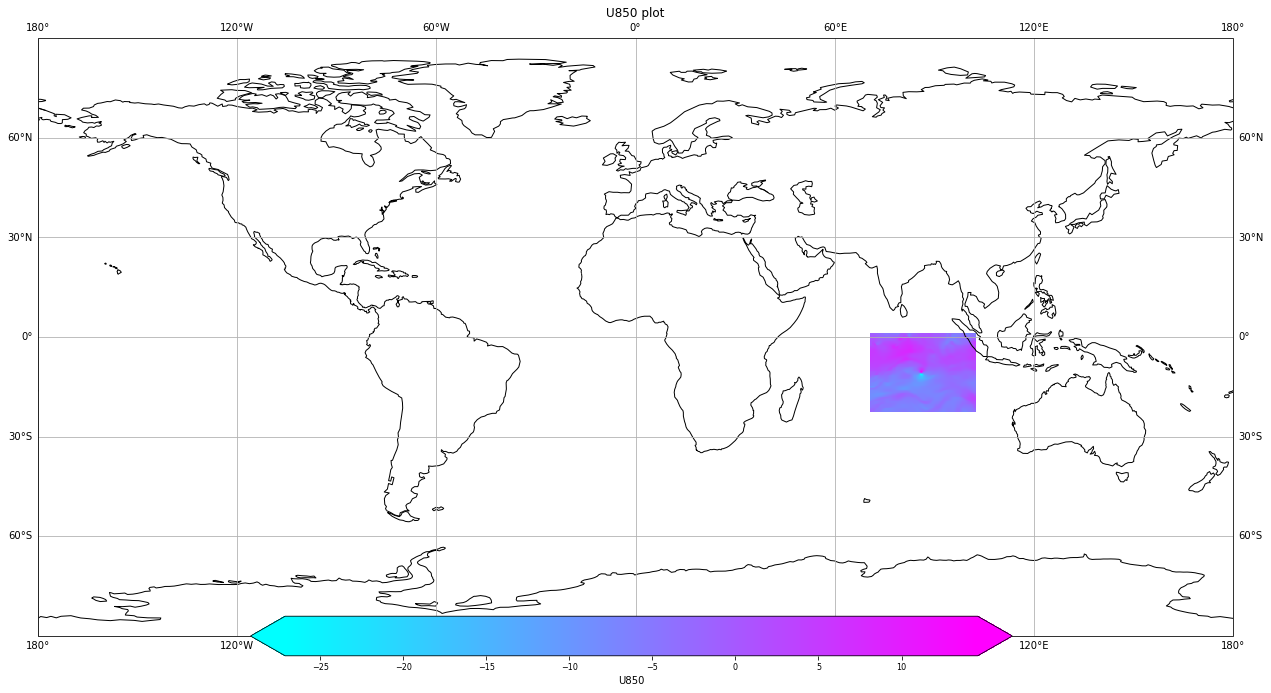

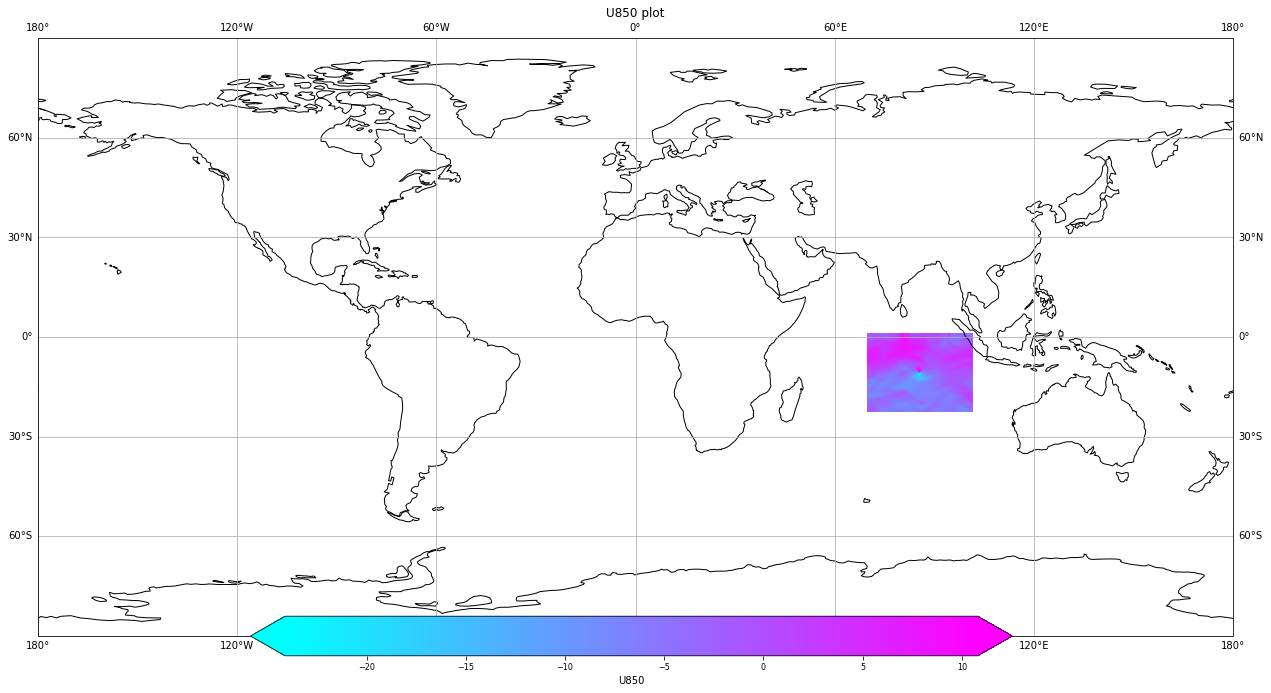

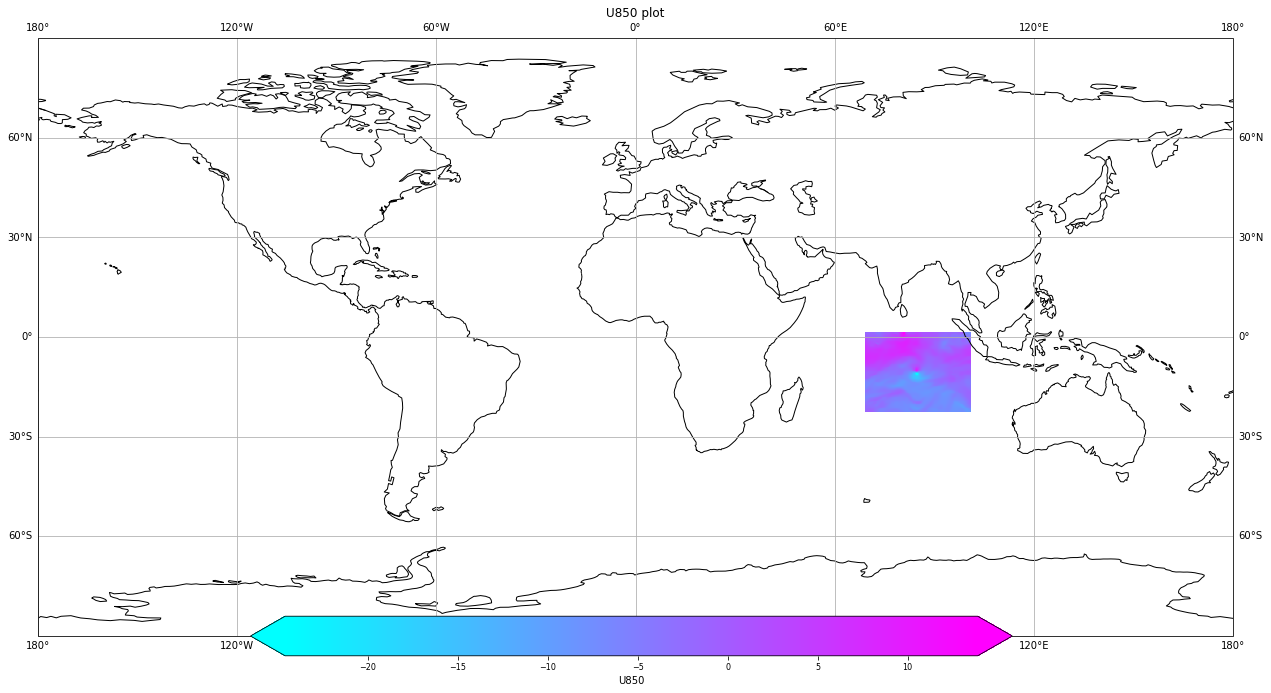

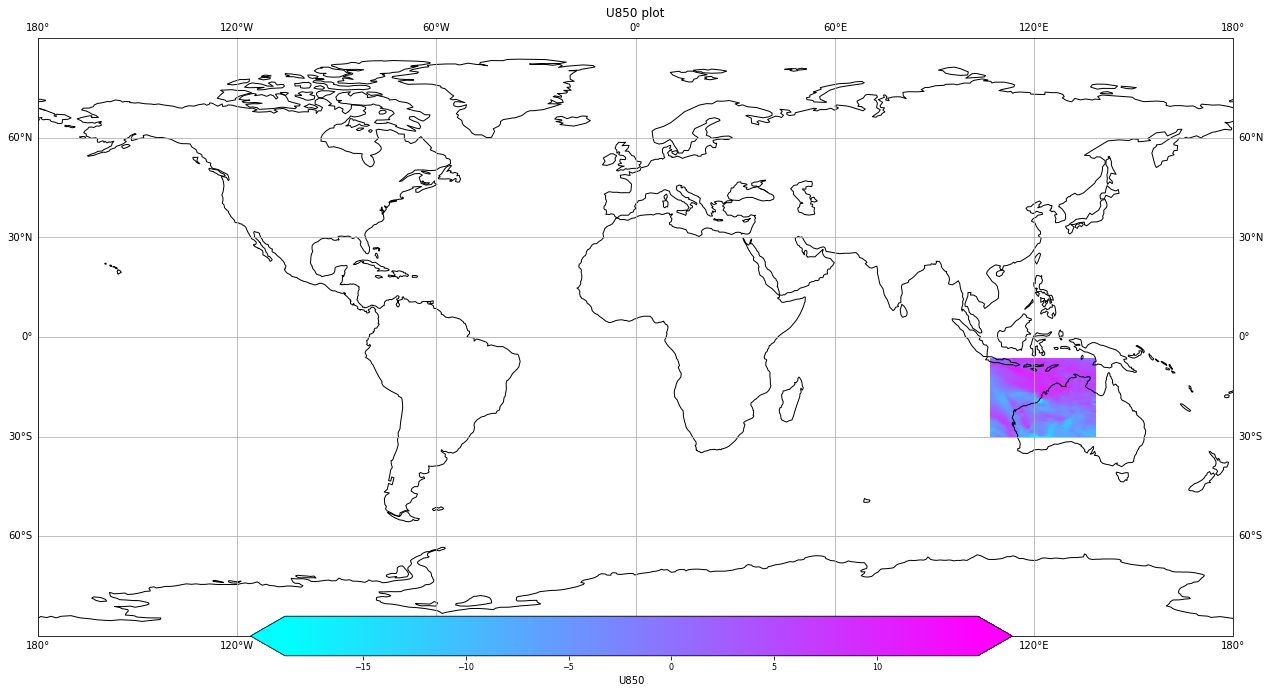

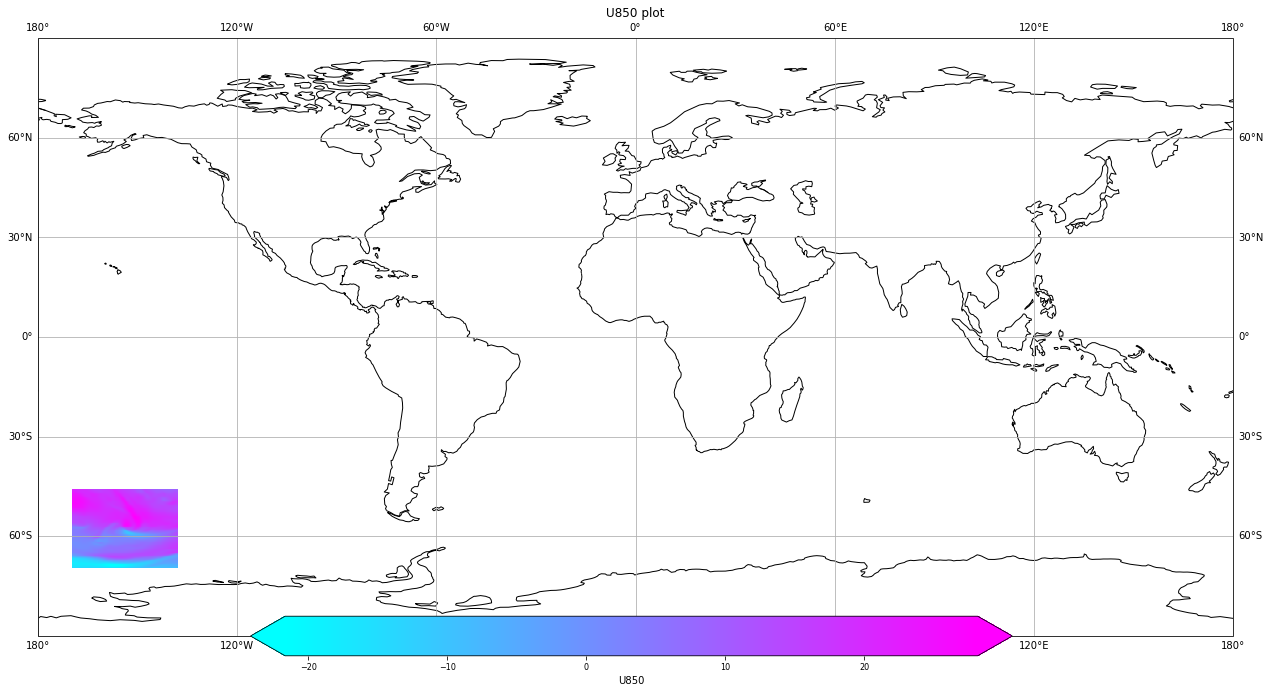

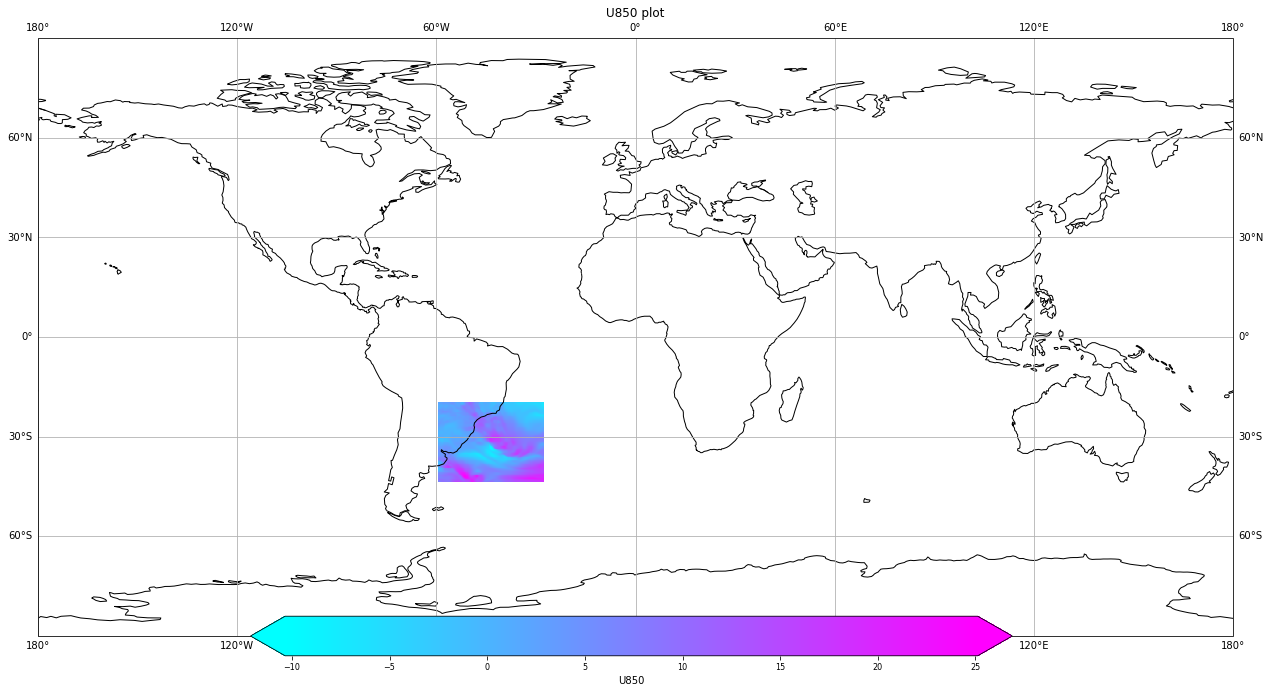

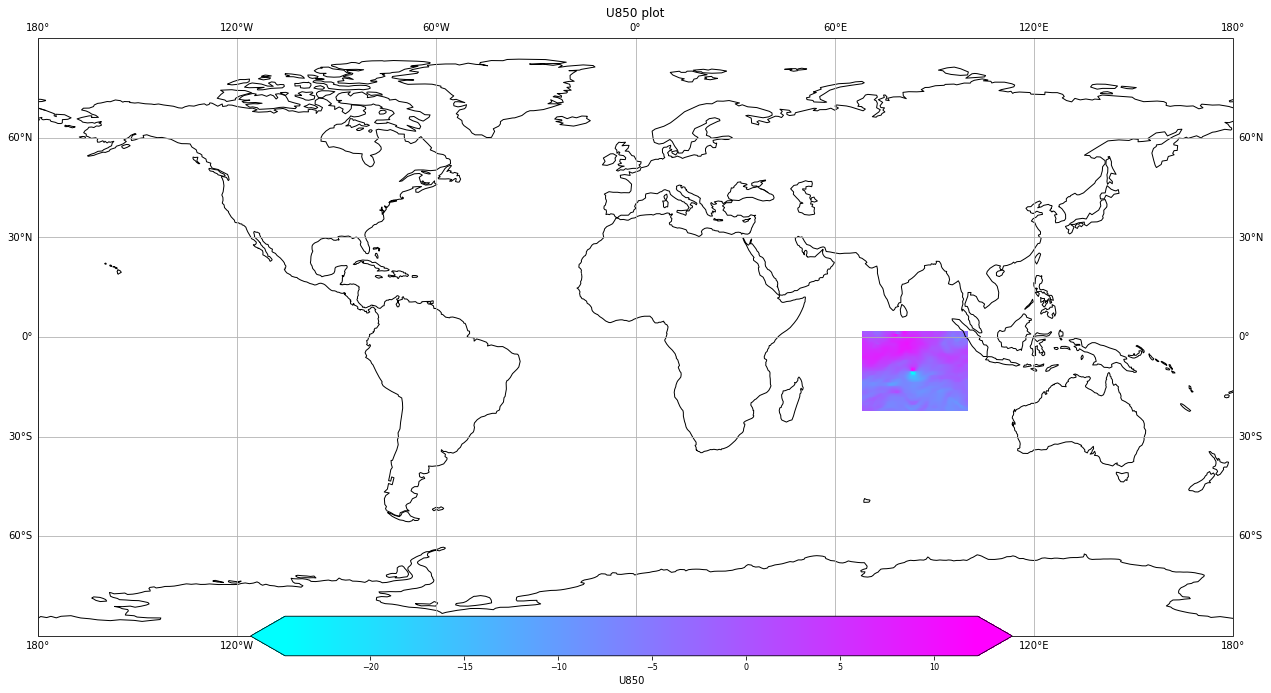

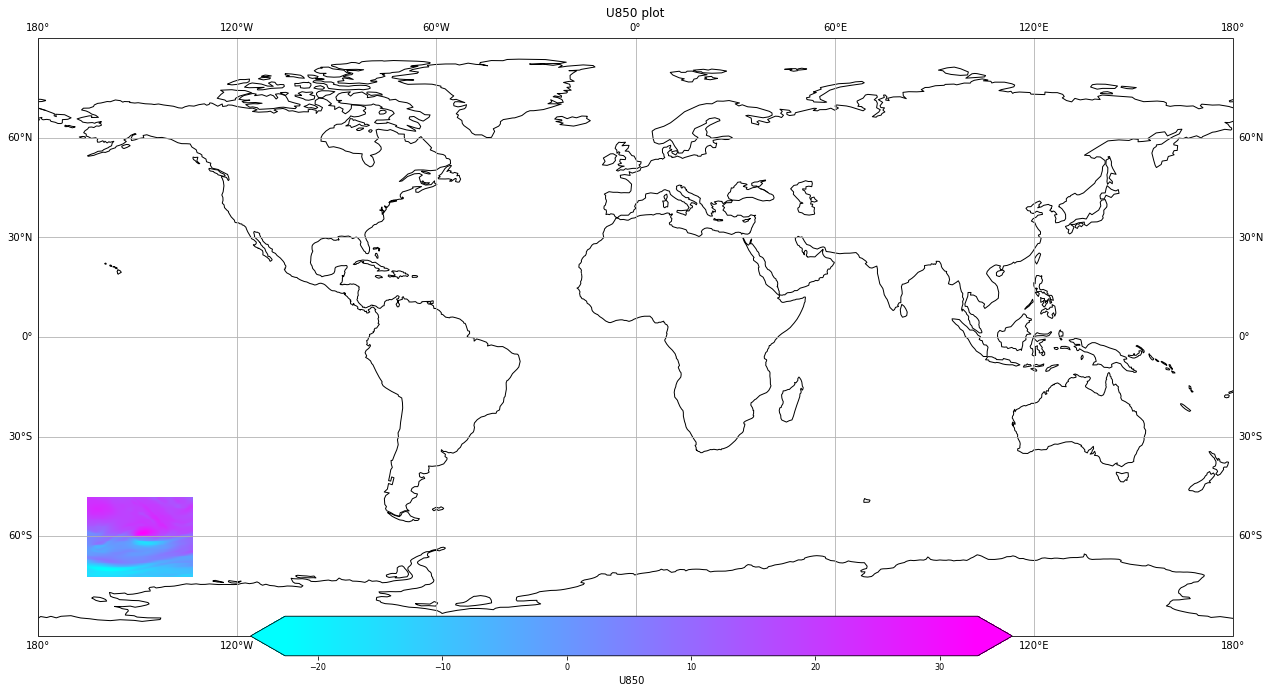

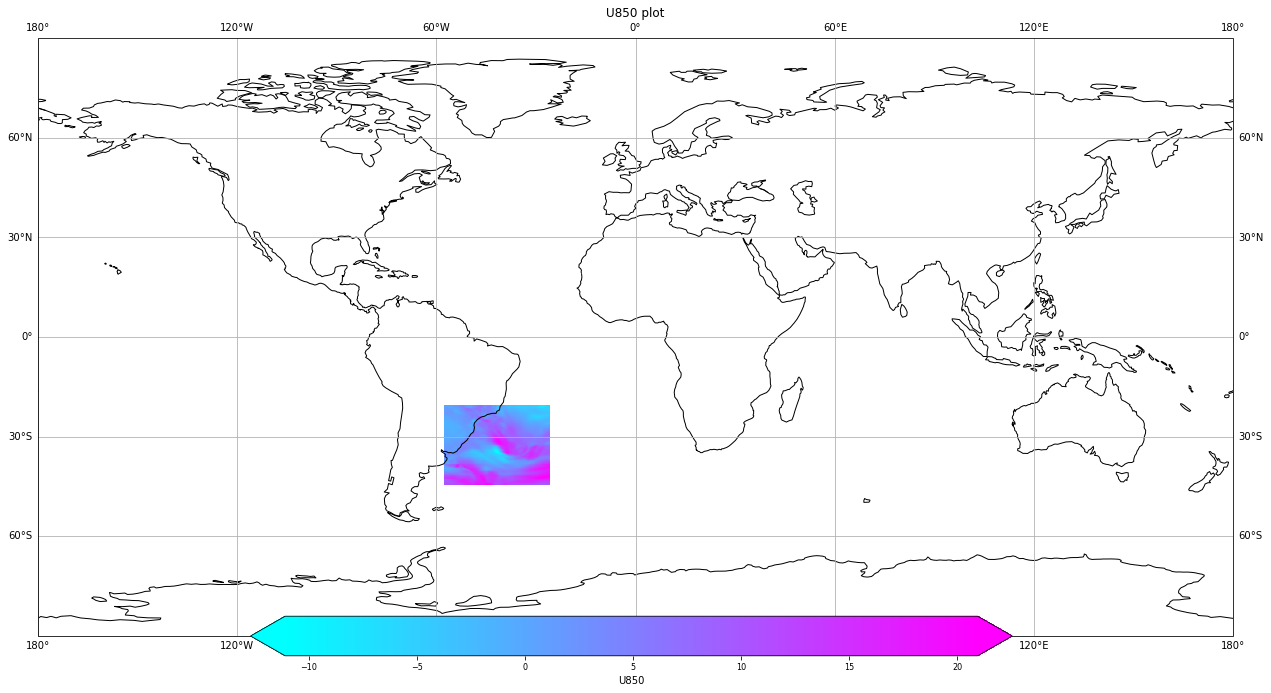

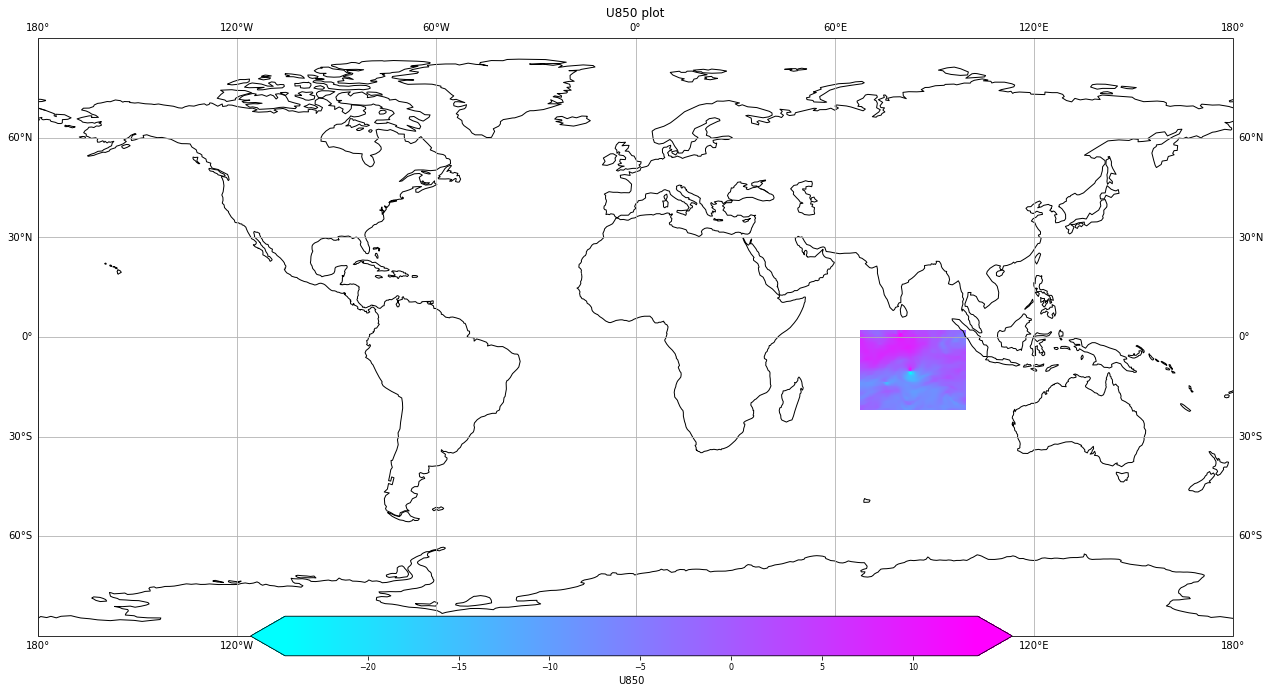

In [170]:
# We already tried pcolormesh (Module 1)
for i in range(10):
    fig = plt.figure(figsize=(23, 11))  # x,y(inches)

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title("U850 plot")
    ax.set_global()
    mm = ax.pcolormesh(np.linspace(data_with_cyclon[i]['lon_min'],
                                   data_with_cyclon[i]['lon_max'], 100),
                       np.linspace(data_with_cyclon[i]['lat_min'],
                                   data_with_cyclon[i]['lat_max'], 100),
                       data_with_cyclon[i]['images'][0, :, :],
                       transform=ccrs.PlateCarree(),
                       cmap=mpl.cm.cool)

    ax.coastlines()
    ax.gridlines(draw_labels=True)

    #- add colorbar
    cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                            0.05])  #[left, bottom, width, height]
    cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
    cbar.set_label('U850')
    cbar.ax.tick_params(labelsize=8)

    plt.show()
    plt.close()

In [164]:
h5f_2 = h5py.File("./data.nosync/georeferenced_pos.h5")

In [166]:
h5f_2.keys()

<KeysViewHDF5 ['images', 'lat_max', 'lat_min', 'lon_max', 'lon_min', 'time']>

In [170]:
h5f_2['time']

<HDF5 dataset "time": shape (432,), type "<i8">

# Numba Time

In [174]:
from numba import jit

In [220]:
import math

In [240]:
from scipy.sparse import csr_matrix

def compute_M(data):
    cols = np.arange(data.size)
    return csr_matrix((cols, (data.ravel(), cols)),
                      shape=(data.max() + 1, data.size))

def get_indices_sparse(data):
    M = compute_M(data)
    return [np.unravel_index(row.data, data.shape) for row in M]

In [242]:
data = np.arange(10)

In [243]:
from scipy.sparse import csr_matrix

def compute_M(data):
    cols = np.arange(data.size)
    return csr_matrix((cols, (data.ravel(), cols)),
                      shape=(data.max() + 1, data.size))

M = compute_M(data)
# return [np.unravel_index(row.data, data.shape) for row in M]

In [255]:
%timeit np.where(data == 2)

1.36 µs ± 61.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [260]:
%timeit np.nonzero(data == 2)

1.59 µs ± 62.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [262]:
%timeit np.argwhere(data == 2)

7.61 µs ± 313 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [263]:
%timeit (data == 2).nonzero()

880 ns ± 16.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [281]:
%timeit (abs(lats[()] +24.758800521512484) < 1e-6).nonzero()

66.5 µs ± 5.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [283]:
%timeit np.argwhere(abs(lats[()] +24.758800521512484) < 1e-6)

83.2 µs ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [282]:
%timeit np.where(abs(lats[()] +24.758800521512484) < 1e-6)

65.3 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [285]:
%timeit np.where(np.isclose(lats[()], 24.758800521512484, 1e-6))

107 µs ± 8.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [287]:
images.shape

(1456, 3, 768, 1152)

In [329]:

def get_box_lat(around=None,
                lat_cyclon_min=None,
                lat_cyclon_max=None):


    ymin_out = (lat_cyclon_min - around)
    ymax_out = (lat_cyclon_max + around)
    #     check if box goes around the edges
    if ymin_out < 0:
        ymin_out = 768 + ymin_out
    if ymax_out > 768:
        ymax_out = ymax_out - 768

    return (ymin_out, ymax_out)


#
#
#
#
#
#

def get_box_lon(around=None,

                lon_cyclon_min=None,
                lon_cyclon_max=None):


    ymin_out = (lon_cyclon_min - around)
    ymax_out = (lon_cyclon_max + around)
    #     check if box goes around the edges
    if ymin_out < 0:
        ymin_out = 1152 + ymin_out
    if ymax_out > 1152:
        ymax_out = ymax_out - 1152

    return (ymin_out, ymax_out)


#
#
#
#
#

def select_box_cyclon(image=None,
                      time=None,
                      lat_cyclon_min=None,
                      lat_cyclon_max=None,
                      lon_cyclon_min=None,
                      lon_cyclon_max=None,
#                       lats=None,
#                       lons=None,
                      around=10):
    assert around > 0, "Please give the box size as positive. You may need to increae the box size for the whole data."
    lat_cyclon_min, lat_cyclon_max = get_box_lat(lat_cyclon_min=lat_cyclon_min,
                                                 lat_cyclon_max=lat_cyclon_max,
                                                 around=around)
    lat_cyclon_min = int(lat_cyclon_min[0])
    lat_cyclon_max = int(lat_cyclon_max[0])
    lon_cyclon_min, lon_cyclon_max = get_box_lon(lon_cyclon_min=lon_cyclon_min,
                                                 lon_cyclon_max=lon_cyclon_max,
                                                 around=around)
    lon_cyclon_min = int(lon_cyclon_min[0])
    lon_cyclon_max = int(lon_cyclon_max[0])
    if lon_cyclon_min > lon_cyclon_max:
        return {
            'lat_min':
            lats[lat_cyclon_min],
            'lat_max':
            lats[lat_cyclon_max],
            'lon_min':
            lons[lon_cyclon_min],
            'lon_max':
            lons[lon_cyclon_max],
            'time':
            time,
            'images':
            np.append(image[:,
                            slice(
                                lat_cyclon_min,
                                lat_cyclon_max),
                            slice(0,
                                  lon_cyclon_max)],
                      image[:,
                            slice(
                                lat_cyclon_min,
                                lat_cyclon_max),
                            slice(lon_cyclon_min, -1)],
                      axis=2)
                            }
    else:
        return {
            'lat_min':
            lats[lat_cyclon_min],
            'lat_max':
            lats[lat_cyclon_max],
            'lon_min':
            lons[lon_cyclon_min],
            'lon_max':
            lons[lon_cyclon_max],
            'time':
            time,
            'images':
            image[:,
                  slice(
                      lat_cyclon_min,
                      lat_cyclon_max),
                  slice(
                      lon_cyclon_min,
                      lon_cyclon_max)]
        }

In [337]:
def do_selection(image = None, 
#                  lats = None, 
#                  lons = None, 
                 cyclon = None, 
                 box_size = 120,
                 i = None
#                  times = times
                ):
    try:
        return (select_box_cyclon(image=image[:, :, :],
                          time=times[i],
                          lat_cyclon_min=[cyclon[0]],
                          lat_cyclon_max=[cyclon[2]],
                          lon_cyclon_min=[cyclon[1]],
                          around=((box_size - abs(cyclon[0] - cyclon[2])) / 2),
                          lon_cyclon_max=[cyclon[3]]))
#                           lats=lats[()],
#                           lons=lons[()])
# )
    except Exception as e:
        print(e)
        warn("For some reason the selection at step %i did not work. May be due to error in data (some latitudes have indexes above 1152)." %i)
        return None

In [333]:
images = images[()]

In [338]:
print("[INFO] Selecting data with cyclons SMALL TEST!")
data_with_cyclon = [
    do_selection(image=images[i],
#                  lats=lats,
#                  lons=lons,
                 cyclon=cyclon,
                 box_size=box_size,
#                  times = times,
                 i=i) for i in progressbar((range(1000)))
    for cyclon in boxes[i][(boxes[i, :, -1] == 2) | (boxes[i, :, -1] == 1)]
]

  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:  00:00:00/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 26 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 27 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 28 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 29 did not work. May be due to error in data (some l

[INFO] Selecting data with cyclons SMALL TEST!
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Index (1152) out of range for (0-1151)
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.


 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:02/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 105 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 107 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 109 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 121 did not work. May be due to error in data (so

Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.


/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 182 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 183 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 187 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 188 did not work. May be due to error in data (some latitudes have indexes above 1152).
 19% (190 of 1000) |###                 

Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.


 26% (266 of 1000) |#####                | Elapsed Time: 0:00:00 ETA:   0:00:01/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 280 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 281 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 282 did not work. May be due to error in data (some latitudes have indexes above 1152).
 29% (292 of 1000) |######               | Elapsed Time: 0:00:00 ETA:   0:00:01/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some

Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.


/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 367 did not work. May be due to error in data (some latitudes have indexes above 1152).
 36% (368 of 1000) |#######              | Elapsed Time: 0:00:00 ETA:   0:00:01/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 378 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 387 did not work. May be due to error in data (some latitudes have indexes above 1152).
 39% (393 of 1000) |########             | Elapsed Time: 0:00:01 ETA:   0:00:01/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some

Index (1152) out of range for (0-1151)
Index (1152) out of range for (0-1151)
Please give the box size as positive. You may need to increae the box size for the whole data.
Index (1152) out of range for (0-1151)


 44% (444 of 1000) |#########            | Elapsed Time: 0:00:01 ETA:   0:00:01/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 451 did not work. May be due to error in data (some latitudes have indexes above 1152).
 46% (469 of 1000) |#########            | Elapsed Time: 0:00:01 ETA:   0:00:01/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 483 did not work. May be due to error in data (some latitudes have indexes above 1152).
 54% (545 of 1000) |###########          | Elapsed Time: 0:00:01 ETA:   0:00:01

Please give the box size as positive. You may need to increae the box size for the whole data.
Index (1152) out of range for (0-1151)


 60% (608 of 1000) |############         | Elapsed Time: 0:00:01 ETA:   0:00:01/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 644 did not work. May be due to error in data (some latitudes have indexes above 1152).
 64% (646 of 1000) |#############        | Elapsed Time: 0:00:01 ETA:   0:00:00/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 647 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 659 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some

Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need

/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 703 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 717 did not work. May be due to error in data (some latitudes have indexes above 1152).
 74% (747 of 1000) |###############      | Elapsed Time: 0:00:01 ETA:   0:00:00/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 770 did not work. May be due to error in data (some latitudes have indexes above 1152).
 77% (773 of 1000) |################     | Elapsed Time: 0:00:02 ETA:   0:00:00/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some

Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Index (1152) out of range for (0-1151)


 83% (836 of 1000) |#################    | Elapsed Time: 0:00:02 ETA:   0:00:00/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 837 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 841 did not work. May be due to error in data (some latitudes have indexes above 1152).
 88% (887 of 1000) |##################   | Elapsed Time: 0:00:02 ETA:   0:00:00/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 920 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some

Please give the box size as positive. You may need to increae the box size for the whole data.
Index (1152) out of range for (0-1151)
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.
Please give the box size as positive. You may need to increae the box size for the whole data.


 95% (950 of 1000) |###################  | Elapsed Time: 0:00:02 ETA:   0:00:00/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 953 did not work. May be due to error in data (some latitudes have indexes above 1152).
 97% (975 of 1000) |#################### | Elapsed Time: 0:00:02 ETA:   0:00:00/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 977 did not work. May be due to error in data (some latitudes have indexes above 1152).
/Users/leonardoalchieri/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: For some reason the selection at step 999 did not work. May be due to error in data (some latitudes have indexes above 1152).
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


Please give the box size as positive. You may need to increae the box size for the whole data.
Index (1152) out of range for (0-1151)
Please give the box size as positive. You may need to increae the box size for the whole data.


In [2]:
h5f = h5py.File('./data.nosync/georeferenced_pos.h5', 'r')

In [3]:
h5f.keys()

<KeysViewHDF5 ['images', 'lat_max', 'lat_min', 'lon_max', 'lon_min', 'time']>

In [4]:
h5f['images']

<HDF5 dataset "images": shape (5655, 3, 120, 120), type "<f4">